# Analyze SHAP values from Optuna model

**Motivation:** Analyze mean absolute shap values from Optuna models

In [303]:
mod = 'ridge'
version = 'v2_mod'

In [304]:
file_name = rf'mean_abs_shap_values__{mod}_{version}'
file_name

'mean_abs_shap_values__ridge_v2_mod'

In [305]:
# set number of clusters
k_clusters = 3

### loads

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# local
import set_path
import supp.support_load as ls
from supp.support_save import save_df

In [307]:
df_original = ls.read_excel(file_name)['mean_abs_shap_values']
df_original = df_original.sort_values(by=['time_id', 'file_name'])
# Removing columns that are entirely NaN
df_original = df_original.dropna(axis=1, how='all')
print(df_original.shape)
df_original.head()

Excel file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\mean_abs_shap_values__ridge_v2_mod.xlsx
(2489, 86)


index model name model modification model param          type  trial  \
715   1304      ridge             weight         NaN  ridge_weight      0   
716   1304      ridge             weight         NaN  ridge_weight      0   
717   1304      ridge             weight         NaN  ridge_weight      0   
718   1304      ridge             weight         NaN  ridge_weight      0   
719   1304      ridge             weight         NaN  ridge_weight      0   

              time_id  n_layers  layer_1  layer_2  ...   Xry-Hbt  \
715  2025032204024740         1       34      NaN  ...  0.020264   
716  2025032204024740         1       34      NaN  ...  0.015228   
717  2025032204024740         1       34      NaN  ...  0.040747   
718  2025032204024740         1       34      NaN  ...  0.027582   
719  2025032204024740         1       34      NaN  ...  0.045618   

    cHD Hm(w)-nTr 9d-cwt-6ti     imA-a  imy-ib n ncwt m ct.f nbt    imy iz  \
715                 0.001801  0.023454                  0.013367  0.040039   
716                 0.015217  0.029714                  0.001668  0.003663   
717                 0.003434  0.014695                  0.029844  0.028219   
718                 0.008191  0.020143                  0.014444  0.046200   
719                 0.057706  0.010146                  0.004400  0.040403   

       r P nb  xrp Hwwt Nt  Hry-tp Nxb  cmcw cnwt  HAty-a mAa  
715  0.026050          NaN    0.101533   0.023920         NaN  
716  0.031904     0.027203    0.079726   0.057447    0.013267  
717  0.006396     0.011783    0.017696   0.047578         NaN  
718  0.022409          NaN    0.008725   0.016641         NaN  
719  0.003605     0.016170    0.041105   0.030692    0.026233  

[5 rows x 86 columns]

In [308]:
# Take only best results
df = df_original.copy()
mask_1 = df['loss'] < 1
mask_2 = df['persons_in_overlap'] < 700
mask_3 = df['epoch'] < 1000
df = df.loc[mask_1 & mask_2 & mask_3, :]
print(df.shape)
df.head()

(2252, 86)


index model name model modification model param          type  trial  \
715   1304      ridge             weight         NaN  ridge_weight      0   
716   1304      ridge             weight         NaN  ridge_weight      0   
717   1304      ridge             weight         NaN  ridge_weight      0   
718   1304      ridge             weight         NaN  ridge_weight      0   
719   1304      ridge             weight         NaN  ridge_weight      0   

              time_id  n_layers  layer_1  layer_2  ...   Xry-Hbt  \
715  2025032204024740         1       34      NaN  ...  0.020264   
716  2025032204024740         1       34      NaN  ...  0.015228   
717  2025032204024740         1       34      NaN  ...  0.040747   
718  2025032204024740         1       34      NaN  ...  0.027582   
719  2025032204024740         1       34      NaN  ...  0.045618   

    cHD Hm(w)-nTr 9d-cwt-6ti     imA-a  imy-ib n ncwt m ct.f nbt    imy iz  \
715                 0.001801  0.023454                  0.013367  0.040039   
716                 0.015217  0.029714                  0.001668  0.003663   
717                 0.003434  0.014695                  0.029844  0.028219   
718                 0.008191  0.020143                  0.014444  0.046200   
719                 0.057706  0.010146                  0.004400  0.040403   

       r P nb  xrp Hwwt Nt  Hry-tp Nxb  cmcw cnwt  HAty-a mAa  
715  0.026050          NaN    0.101533   0.023920         NaN  
716  0.031904     0.027203    0.079726   0.057447    0.013267  
717  0.006396     0.011783    0.017696   0.047578         NaN  
718  0.022409          NaN    0.008725   0.016641         NaN  
719  0.003605     0.016170    0.041105   0.030692    0.026233  

[5 rows x 86 columns]

In [309]:
df_shap = df.loc[:, 'file_name':].set_index('file_name')
print(df_shap.shape)
df_shap.head()

(2252, 60)


cmr waty n it.f  \
file_name                                               
ridge_weight__2025032204024740__0.pt         0.057374   
ridge_weight__2025032204024740__1.pt         0.063609   
ridge_weight__2025032204024740__2.pt         0.020192   
ridge_weight__2025032204024740__3.pt         0.031048   
ridge_weight__2025032204024740__4.pt              NaN   

                                      imy-rA zS(w) a(w) (nw) ncwt    HAty-a  \
file_name                                                                     
ridge_weight__2025032204024740__0.pt                     0.130475  0.185870   
ridge_weight__2025032204024740__1.pt                     0.146610  0.181328   
ridge_weight__2025032204024740__2.pt                     0.071114  0.097617   
ridge_weight__2025032204024740__3.pt                     0.061654  0.078768   
ridge_weight__2025032204024740__4.pt                     0.091594  0.127634   

                                      wr 5 (m) pr 9Hwty   iry-pat  \
file_name                                                           
ridge_weight__2025032204024740__0.pt           0.074133  0.172172   
ridge_weight__2025032204024740__1.pt           0.093626  0.221582   
ridge_weight__2025032204024740__2.pt           0.037523  0.088855   
ridge_weight__2025032204024740__3.pt           0.036121  0.064284   
ridge_weight__2025032204024740__4.pt           0.188502  0.149495   

                                      imy-rA Snwty  father_was_vizier  \
file_name                                                               
ridge_weight__2025032204024740__0.pt      0.103332           0.020384   
ridge_weight__2025032204024740__1.pt      0.108890           0.052169   
ridge_weight__2025032204024740__2.pt      0.046531           0.004453   
ridge_weight__2025032204024740__3.pt      0.057022           0.002850   
ridge_weight__2025032204024740__4.pt      0.076874           0.012044   

                                           PC1       PC3       PC2  ...  \
file_name                                                           ...   
ridge_weight__2025032204024740__0.pt  0.041468  0.012796  0.016807  ...   
ridge_weight__2025032204024740__1.pt  0.035073  0.014874  0.017010  ...   
ridge_weight__2025032204024740__2.pt  0.062510  0.027397  0.023151  ...   
ridge_weight__2025032204024740__3.pt  0.069921  0.012722  0.008522  ...   
ridge_weight__2025032204024740__4.pt  0.039034  0.016047  0.014485  ...   

                                       Xry-Hbt  cHD Hm(w)-nTr 9d-cwt-6ti  \
file_name                                                                  
ridge_weight__2025032204024740__0.pt  0.020264                  0.001801   
ridge_weight__2025032204024740__1.pt  0.015228                  0.015217   
ridge_weight__2025032204024740__2.pt  0.040747                  0.003434   
ridge_weight__2025032204024740__3.pt  0.027582                  0.008191   
ridge_weight__2025032204024740__4.pt  0.045618                  0.057706   

                                         imA-a  imy-ib n ncwt m ct.f nbt  \
file_name                                                                  
ridge_weight__2025032204024740__0.pt  0.023454                  0.013367   
ridge_weight__2025032204024740__1.pt  0.029714                  0.001668   
ridge_weight__2025032204024740__2.pt  0.014695                  0.029844   
ridge_weight__2025032204024740__3.pt  0.020143                  0.014444   
ridge_weight__2025032204024740__4.pt  0.010146                  0.004400   

                                        imy iz    r P nb  xrp Hwwt Nt  \
file_name                                                               
ridge_weight__2025032204024740__0.pt  0.040039  0.026050          NaN   
ridge_weight__2025032204024740__1.pt  0.003663  0.031904     0.027203   
ridge_weight__2025032204024740__2.pt  0.028219  0.006396     0.011783   
ridge_weight__2025032204024740__3.pt  0.046200  0.022409          NaN   
ridge_weight__2025032204024740__4.pt  0.040403  0.003605  

In [310]:
features = df_shap.columns.to_list()
print(len(features))
print(features)

60
['cmr waty n it.f', 'imy-rA zS(w) a(w) (nw) ncwt', 'HAty-a', 'wr 5 (m) pr 9Hwty', 'iry-pat', 'imy-rA Snwty', 'father_was_vizier', 'PC1', 'PC3', 'PC2', 'dyn_num', 'imy-rA Xnw', 'zA ncwt n Xt.f cmcw', 'imy-rA wcxt', 'iwn knmwt', 'imy-rA kAt nbt (nt) ncwt', 'zA ncwt n Xt.f', 'cmr waty', 'xtm(ty)-bity', 'Xry-tp ncwt', 'imy-rA prwy-HD', 'mDH ncwt qd(w) m prwy', 'cm / ctm', 'Hry-cStA n wD(t)-mdw nbt nt ncwt', 'zS mDAt-nTr', 'Xry-Hbt Hry-tp', 'imy-rA gc-pr', 'imy-rA wabty', '[imAxw xr] nTr aA', 'Hm BAw Nxn', 'xt Wr', 'imy-rA izwy (nw) Xry-xtmt', 'xt ...?', 'imy-rA izwy (n) Xkr(w) ncwt', 'xrp SnDt nbt', 'aA 8wAw', 'wa (m) wr(w) Hb', 'aD-mr 8p', 'mdw 1p', 'xrp iAwt nbwt nTrwt', 'imAxw', 'Hm-nTr 1r qA-a', 'Hry wrw', 'mDH zS(w) ncwt', 'Hry-cStA n pr-dwAt', 'imy iz Nxn', 'cmA 1r', 'imy-rA gcwy-pr', 'imy-rA prwy-nbw', 'wt(y) Inpw', 'Xry-Hbt', 'cHD Hm(w)-nTr 9d-cwt-6ti', 'imA-a', 'imy-ib n ncwt m ct.f nbt', 'imy iz', 'r P nb', 'xrp Hwwt Nt', 'Hry-tp Nxb', 'cmcw cnwt', 'HAty-a mAa']


In [311]:
# drop rows with all SHAP values equal to nan
df = df.dropna(subset=features, how='all')
# fill nan shaps with 0
df[features] = df[features].fillna(0)
# normalized features
df[features] = df[features].div(df[features].sum(axis=1), axis=0)
# drop rows with all SHAP values equal to nan
df = df.dropna(subset=features, how='all')

### analyze

In [312]:
df['file_name'].apply(lambda x: x[:-6])

715     ridge_weight__2025032204024740
716     ridge_weight__2025032204024740
717     ridge_weight__2025032204024740
718     ridge_weight__2025032204024740
719     ridge_weight__2025032204024740
                     ...              
2078           ridge__2025032214164860
2079           ridge__2025032214164860
2080           ridge__2025032214164860
2081           ridge__2025032214170380
2082           ridge__2025032214170380
Name: file_name, Length: 2242, dtype: object

In [313]:
# Function to calculate pairwise cosine similarity for each group
def calculate_similarity(group):
    # Sort values
    df1 = group.sort_values(by='group')
    # Extract only the numerical columns for similarity computation
    df1 = df1.loc[:, features]  # Adjust if your feature columns differ
    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(df1)
    # Extract elements below the main diagonal
    lower_triangle = sim_matrix[np.tril_indices(sim_matrix.shape[0], k=-1)]
    s = pd.Series(lower_triangle).describe()
    return s

# Apply the function to each group
df['group'] = df['file_name'].apply(lambda x: x[:-6])
df_similarity = df.groupby('group').apply(calculate_similarity)

# Add max_diff column
df_similarity['max_diff'] = df_similarity['max'] - df_similarity['min']

# Print the cosine similarity matrices for each group
print(df_similarity.shape)
df_similarity = df_similarity[df_similarity['count']>1]
print(df_similarity.shape)
df_similarity.head()

(497, 9)
(455, 9)


count      mean       std       min       25%  \
group                                                                    
ridge__2025032211333440   10.0  0.536610  0.126159  0.393864  0.438564   
ridge__2025032211345020   10.0  0.832876  0.022260  0.809151  0.816548   
ridge__2025032211531580   10.0  0.705982  0.058842  0.587650  0.682311   
ridge__2025032211541500    6.0  0.573795  0.124535  0.387677  0.524427   
ridge__2025032211545040   10.0  0.862182  0.023461  0.832334  0.850271   

                              50%       75%       max  max_diff  
group                                                            
ridge__2025032211333440  0.527882  0.606081  0.752432  0.358568  
ridge__2025032211345020  0.829600  0.841090  0.879257  0.070106  
ridge__2025032211531580  0.694431  0.740203  0.803197  0.215547  
ridge__2025032211541500  0.569242  0.628841  0.758414  0.370737  
ridge__2025032211545040  0.863798  0.869855  0.913382  0.081048

#### Analyze mean

In [314]:
df_similarity.sort_values(by='mean', ascending=True).head(10)

count      mean       std       min  \
group                                                                    
ridge_do_05__2025032206250090        6.0  0.483786  0.149248  0.291423   
ridge_small_mse__2025032212293160   10.0  0.503649  0.311289  0.116067   
ridge_do_03__2025032212012600        3.0  0.518265  0.113313  0.448903   
ridge_weight__2025032204183820      10.0  0.528342  0.131862  0.335506   
ridge_l2_05__2025032205291720       10.0  0.529408  0.112983  0.347364   
ridge_weight__2025032204165620      10.0  0.532687  0.103703  0.387533   
ridge__2025032211333440             10.0  0.536610  0.126159  0.393864   
ridge__2025032213474690             10.0  0.537005  0.163655  0.212747   
ridge_do_05__2025032206244700       10.0  0.539069  0.112330  0.342328   
ridge_l2_05__2025032205561010       10.0  0.539643  0.113615  0.406246   

                                        25%       50%       75%       max  \
group                                                                       
ridge_do_05__2025032206250090      0.417582  0.435174  0.597986  0.676969   
ridge_small_mse__2025032212293160  0.171182  0.688895  0.753864  0.820446   
ridge_do_03__2025032212012600      0.452884  0.456866  0.552947  0.649027   
ridge_weight__2025032204183820     0.439124  0.502860  0.610520  0.734229   
ridge_l2_05__2025032205291720      0.479285  0.540384  0.612128  0.690892   
ridge_weight__2025032204165620     0.446771  0.529015  0.600610  0.693818   
ridge__2025032211333440            0.438564  0.527882  0.606081  0.752432   
ridge__2025032213474690            0.441584  0.570470  0.674999  0.723736   
ridge_do_05__2025032206244700      0.507134  0.533802  0.550449  0.761734   
ridge_l2_05__2025032205561010      0.447500  0.498681  0.648315  0.708849   

                                   max_diff  
group                                        
ridge_do_05__2025032206250090      0.385545  
ridge_small_mse__2025032212293160  0.704379  
ridge_do_03__2025032212012600      0.200125  
ridge_weight__2025032204183820     0.398723  
ridge_l2_05__2025032205291720      0.343527  
ridge_weight__2025032204165620     0.306285  
ridge__2025032211333440            0.358568  
ridge__2025032213474690            0.510989  
ridge_do_05__2025032206244700      0.419406  
ridge_l2_05__2025032205561010      0.302603

In [315]:
df.loc[df['time_id']==2025030713415130, features]

Empty DataFrame
Columns: [cmr waty n it.f, imy-rA zS(w) a(w) (nw) ncwt, HAty-a, wr 5 (m) pr 9Hwty, iry-pat, imy-rA Snwty, father_was_vizier, PC1, PC3, PC2, dyn_num, imy-rA Xnw, zA ncwt n Xt.f cmcw, imy-rA wcxt, iwn knmwt, imy-rA kAt nbt (nt) ncwt, zA ncwt n Xt.f, cmr waty, xtm(ty)-bity, Xry-tp ncwt, imy-rA prwy-HD, mDH ncwt qd(w) m prwy, cm / ctm, Hry-cStA n wD(t)-mdw nbt nt ncwt, zS mDAt-nTr, Xry-Hbt Hry-tp, imy-rA gc-pr, imy-rA wabty, [imAxw xr] nTr aA, Hm BAw Nxn, xt Wr, imy-rA izwy (nw) Xry-xtmt, xt ...?, imy-rA izwy (n) Xkr(w) ncwt, xrp SnDt nbt, aA 8wAw, wa (m) wr(w) Hb, aD-mr 8p, mdw 1p, xrp iAwt nbwt nTrwt, imAxw, Hm-nTr 1r qA-a, Hry wrw, mDH zS(w) ncwt, Hry-cStA n pr-dwAt, imy iz Nxn, cmA 1r, imy-rA gcwy-pr, imy-rA prwy-nbw, wt(y) Inpw, Xry-Hbt, cHD Hm(w)-nTr 9d-cwt-6ti, imA-a, imy-ib n ncwt m ct.f nbt, imy iz, r P nb, xrp Hwwt Nt, Hry-tp Nxb, cmcw cnwt, HAty-a mAa]
Index: []

[0 rows x 60 columns]

In [316]:
df_similarity.sort_values(by='mean', ascending=False).head(10)

count      mean       std       min       25%  \
group                                                                          
ridge_l2_02__2025032205110620   10.0  0.987130  0.004543  0.977453  0.984734   
ridge_l2_02__2025032205570600   10.0  0.933919  0.014404  0.910020  0.928611   
ridge_l2_02__2025032205591640   10.0  0.933805  0.014112  0.912661  0.922027   
ridge_l2_02__2025032205365660   10.0  0.933469  0.016884  0.905191  0.922306   
ridge_l2_02__2025032205553290   10.0  0.932623  0.017437  0.907199  0.917053   
ridge_l2_02__2025032205460030   10.0  0.932398  0.015672  0.902422  0.928863   
ridge_l2_02__2025032205080990   10.0  0.931386  0.019417  0.907415  0.912629   
ridge_l2_02__2025032205471590   10.0  0.930083  0.016432  0.906371  0.917442   
ridge_l2_02__2025032205580250   10.0  0.929397  0.012989  0.912300  0.920077   
ridge_l2_02__2025032205414540    3.0  0.928870  0.029803  0.908383  0.911775   

                                    50%       75%       max  max_diff  
group                                                                  
ridge_l2_02__2025032205110620  0.987949  0.990390  0.992984  0.015530  
ridge_l2_02__2025032205570600  0.936136  0.939672  0.961100  0.051080  
ridge_l2_02__2025032205591640  0.935338  0.946906  0.949387  0.036726  
ridge_l2_02__2025032205365660  0.936402  0.945213  0.957129  0.051938  
ridge_l2_02__2025032205553290  0.936563  0.943177  0.960777  0.053578  
ridge_l2_02__2025032205460030  0.933693  0.941759  0.955430  0.053008  
ridge_l2_02__2025032205080990  0.934185  0.943299  0.962457  0.055043  
ridge_l2_02__2025032205471590  0.930815  0.939699  0.960842  0.054471  
ridge_l2_02__2025032205580250  0.926482  0.939187  0.950310  0.038010  
ridge_l2_02__2025032205414540  0.915167  0.939113  0.963060  0.054677

In [317]:
df.loc[df['time_id']==2025022815152500, features]

Empty DataFrame
Columns: [cmr waty n it.f, imy-rA zS(w) a(w) (nw) ncwt, HAty-a, wr 5 (m) pr 9Hwty, iry-pat, imy-rA Snwty, father_was_vizier, PC1, PC3, PC2, dyn_num, imy-rA Xnw, zA ncwt n Xt.f cmcw, imy-rA wcxt, iwn knmwt, imy-rA kAt nbt (nt) ncwt, zA ncwt n Xt.f, cmr waty, xtm(ty)-bity, Xry-tp ncwt, imy-rA prwy-HD, mDH ncwt qd(w) m prwy, cm / ctm, Hry-cStA n wD(t)-mdw nbt nt ncwt, zS mDAt-nTr, Xry-Hbt Hry-tp, imy-rA gc-pr, imy-rA wabty, [imAxw xr] nTr aA, Hm BAw Nxn, xt Wr, imy-rA izwy (nw) Xry-xtmt, xt ...?, imy-rA izwy (n) Xkr(w) ncwt, xrp SnDt nbt, aA 8wAw, wa (m) wr(w) Hb, aD-mr 8p, mdw 1p, xrp iAwt nbwt nTrwt, imAxw, Hm-nTr 1r qA-a, Hry wrw, mDH zS(w) ncwt, Hry-cStA n pr-dwAt, imy iz Nxn, cmA 1r, imy-rA gcwy-pr, imy-rA prwy-nbw, wt(y) Inpw, Xry-Hbt, cHD Hm(w)-nTr 9d-cwt-6ti, imA-a, imy-ib n ncwt m ct.f nbt, imy iz, r P nb, xrp Hwwt Nt, Hry-tp Nxb, cmcw cnwt, HAty-a mAa]
Index: []

[0 rows x 60 columns]

#### Analyze std

In [318]:
df_similarity.sort_values(by='std', ascending=True).head(10)

count      mean       std       min       25%  \
group                                                                          
ridge_l2_02__2025032205110620   10.0  0.987130  0.004543  0.977453  0.984734   
ridge_l2_02__2025032205360880    6.0  0.925987  0.011479  0.912572  0.917392   
ridge_l2_02__2025032205580250   10.0  0.929397  0.012989  0.912300  0.920077   
ridge_l2_02__2025032205591640   10.0  0.933805  0.014112  0.912661  0.922027   
ridge_l2_02__2025032205570600   10.0  0.933919  0.014404  0.910020  0.928611   
ridge_l2_02__2025032206000540   10.0  0.887300  0.015611  0.867185  0.877957   
ridge_l2_02__2025032205460030   10.0  0.932398  0.015672  0.902422  0.928863   
ridge_l2_02__2025032205445610   10.0  0.928470  0.015835  0.893419  0.922201   
ridge_l2_02__2025032206033180   10.0  0.910179  0.016133  0.881943  0.897992   
ridge_l2_02__2025032205471590   10.0  0.930083  0.016432  0.906371  0.917442   

                                    50%       75%       max  max_diff  
group                                                                  
ridge_l2_02__2025032205110620  0.987949  0.990390  0.992984  0.015530  
ridge_l2_02__2025032205360880  0.924810  0.935696  0.939487  0.026915  
ridge_l2_02__2025032205580250  0.926482  0.939187  0.950310  0.038010  
ridge_l2_02__2025032205591640  0.935338  0.946906  0.949387  0.036726  
ridge_l2_02__2025032205570600  0.936136  0.939672  0.961100  0.051080  
ridge_l2_02__2025032206000540  0.883747  0.896045  0.914542  0.047356  
ridge_l2_02__2025032205460030  0.933693  0.941759  0.955430  0.053008  
ridge_l2_02__2025032205445610  0.932323  0.936596  0.949810  0.056392  
ridge_l2_02__2025032206033180  0.916428  0.919674  0.928319  0.046376  
ridge_l2_02__2025032205471590  0.930815  0.939699  0.960842  0.054471

In [319]:
df_similarity.sort_values(by='std', ascending=False).head(10)

count      mean       std       min  \
group                                                                    
ridge_small_mse__2025032212293160   10.0  0.503649  0.311289  0.116067   
ridge_weight__2025032204195770      10.0  0.711723  0.218587  0.372548   
ridge_small_mse__2025032212004980    3.0  0.599602  0.178519  0.480949   
ridge_weight__2025032204113430      10.0  0.763749  0.171159  0.500057   
ridge_weight__2025032204351850      10.0  0.782313  0.167033  0.556877   
ridge__2025032213474690             10.0  0.537005  0.163655  0.212747   
ridge_weight__2025032204355240      10.0  0.793031  0.158380  0.587321   
ridge_do_01__2025032212165090       10.0  0.677444  0.155754  0.470809   
ridge_do_05__2025032206250090        6.0  0.483786  0.149248  0.291423   
ridge_do_03__2025032212043340        3.0  0.569754  0.142643  0.486536   

                                        25%       50%       75%       max  \
group                                                                       
ridge_small_mse__2025032212293160  0.171182  0.688895  0.753864  0.820446   
ridge_weight__2025032204195770     0.537947  0.736997  0.908703  0.957328   
ridge_small_mse__2025032212004980  0.496949  0.512948  0.658928  0.804908   
ridge_weight__2025032204113430     0.624947  0.834627  0.905554  0.924558   
ridge_weight__2025032204351850     0.599260  0.884685  0.916214  0.942898   
ridge__2025032213474690            0.441584  0.570470  0.674999  0.723736   
ridge_weight__2025032204355240     0.618005  0.902626  0.917261  0.928654   
ridge_do_01__2025032212165090      0.526026  0.731605  0.816625  0.858284   
ridge_do_05__2025032206250090      0.417582  0.435174  0.597986  0.676969   
ridge_do_03__2025032212043340      0.487401  0.488266  0.611364  0.734461   

                                   max_diff  
group                                        
ridge_small_mse__2025032212293160  0.704379  
ridge_weight__2025032204195770     0.584780  
ridge_small_mse__2025032212004980  0.323959  
ridge_weight__2025032204113430     0.424501  
ridge_weight__2025032204351850     0.386021  
ridge__2025032213474690            0.510989  
ridge_weight__2025032204355240     0.341334  
ridge_do_01__2025032212165090      0.387475  
ridge_do_05__2025032206250090      0.385545  
ridge_do_03__2025032212043340      0.247926

#### Analyze max_diff

In [320]:
df_similarity.sort_values(by='max_diff', ascending=True).head(10)

count      mean       std       min       25%  \
group                                                                           
ridge_l2_02__2025032205110620    10.0  0.987130  0.004543  0.977453  0.984734   
ridge_l2_02__2025032205360880     6.0  0.925987  0.011479  0.912572  0.917392   
ridge_weight__2025032204234100    3.0  0.799702  0.017129  0.785905  0.790116   
ridge_weight__2025032204265120    3.0  0.869576  0.019273  0.855383  0.858605   
ridge_do_01__2025032212062920     3.0  0.641048  0.018148  0.622581  0.632142   
ridge_l2_02__2025032205591640    10.0  0.933805  0.014112  0.912661  0.922027   
ridge_l2_02__2025032205580250    10.0  0.929397  0.012989  0.912300  0.920077   
ridge_l2_02__2025032205342680     3.0  0.926492  0.020246  0.904458  0.917601   
ridge_do_01__2025032211581800     3.0  0.859244  0.021526  0.843670  0.846962   
ridge_do_01__2025032212063690     3.0  0.875311  0.023197  0.855942  0.862457   

                                     50%       75%       max  max_diff  
group                                                                   
ridge_l2_02__2025032205110620   0.987949  0.990390  0.992984  0.015530  
ridge_l2_02__2025032205360880   0.924810  0.935696  0.939487  0.026915  
ridge_weight__2025032204234100  0.794327  0.806600  0.818873  0.032968  
ridge_weight__2025032204265120  0.861828  0.876673  0.891518  0.036135  
ridge_do_01__2025032212062920   0.641704  0.650281  0.658859  0.036278  
ridge_l2_02__2025032205591640   0.935338  0.946906  0.949387  0.036726  
ridge_l2_02__2025032205580250   0.926482  0.939187  0.950310  0.038010  
ridge_l2_02__2025032205342680   0.930744  0.937510  0.944275  0.039816  
ridge_do_01__2025032211581800   0.850254  0.867031  0.883808  0.040138  
ridge_do_01__2025032212063690   0.868972  0.884996  0.901019  0.045077

In [321]:
df.loc[df['time_id']==2025030714431570, features]

Empty DataFrame
Columns: [cmr waty n it.f, imy-rA zS(w) a(w) (nw) ncwt, HAty-a, wr 5 (m) pr 9Hwty, iry-pat, imy-rA Snwty, father_was_vizier, PC1, PC3, PC2, dyn_num, imy-rA Xnw, zA ncwt n Xt.f cmcw, imy-rA wcxt, iwn knmwt, imy-rA kAt nbt (nt) ncwt, zA ncwt n Xt.f, cmr waty, xtm(ty)-bity, Xry-tp ncwt, imy-rA prwy-HD, mDH ncwt qd(w) m prwy, cm / ctm, Hry-cStA n wD(t)-mdw nbt nt ncwt, zS mDAt-nTr, Xry-Hbt Hry-tp, imy-rA gc-pr, imy-rA wabty, [imAxw xr] nTr aA, Hm BAw Nxn, xt Wr, imy-rA izwy (nw) Xry-xtmt, xt ...?, imy-rA izwy (n) Xkr(w) ncwt, xrp SnDt nbt, aA 8wAw, wa (m) wr(w) Hb, aD-mr 8p, mdw 1p, xrp iAwt nbwt nTrwt, imAxw, Hm-nTr 1r qA-a, Hry wrw, mDH zS(w) ncwt, Hry-cStA n pr-dwAt, imy iz Nxn, cmA 1r, imy-rA gcwy-pr, imy-rA prwy-nbw, wt(y) Inpw, Xry-Hbt, cHD Hm(w)-nTr 9d-cwt-6ti, imA-a, imy-ib n ncwt m ct.f nbt, imy iz, r P nb, xrp Hwwt Nt, Hry-tp Nxb, cmcw cnwt, HAty-a mAa]
Index: []

[0 rows x 60 columns]

In [322]:
df_similarity.sort_values(by='max_diff', ascending=False).head(30)

count      mean       std       min  \
group                                                                    
ridge_small_mse__2025032212293160   10.0  0.503649  0.311289  0.116067   
ridge_weight__2025032204195770      10.0  0.711723  0.218587  0.372548   
ridge__2025032213474690             10.0  0.537005  0.163655  0.212747   
ridge__2025032213522440             10.0  0.612846  0.116428  0.344669   
ridge_small_mse__2025032212205530   10.0  0.613930  0.113084  0.401086   
ridge_weight__2025032204113430      10.0  0.763749  0.171159  0.500057   
ridge_l2_05__2025032205282610       10.0  0.574492  0.123006  0.345217   
ridge_do_05__2025032206244700       10.0  0.539069  0.112330  0.342328   
ridge_weight__2025032204152810      10.0  0.602153  0.122273  0.326562   
ridge_small_mse__2025032212203770   10.0  0.583576  0.109565  0.333204   
ridge_weight__2025032204183820      10.0  0.528342  0.131862  0.335506   
ridge_do_01__2025032212165090       10.0  0.677444  0.155754  0.470809   
ridge_weight__2025032204351850      10.0  0.782313  0.167033  0.556877   
ridge_do_05__2025032206250090        6.0  0.483786  0.149248  0.291423   
ridge_small_mse__2025032212114020   10.0  0.603013  0.121310  0.437866   
ridge__2025032211541500              6.0  0.573795  0.124535  0.387677   
ridge_do_05__2025032205594910        6.0  0.637784  0.131645  0.421063   
ridge_do_01__2025032212015980       10.0  0.580926  0.110194  0.407775   
ridge_small_mse__2025032211474240   10.0  0.654480  0.104238  0.479985   
ridge__2025032211333440             10.0  0.536610  0.126159  0.393864   
ridge_weight__2025032204033530      10.0  0.784944  0.132871  0.555679   
ridge_do_01__2025032212405350       10.0  0.616025  0.104497  0.438207   
ridge__2025032213482130             10.0  0.614933  0.112631  0.393023   
ridge_small_mse__2025032212381710   10.0  0.557683  0.118222  0.402680   
ridge_small_mse__2025032212210880   10.0  0.619507  0.114590  0.463999   
ridge_l2_05__2025032205291720       10.0  0.529408  0.112983  0.347364   
ridge_small_mse__2025032212122680   10.0  0.595087  0.116501  0.432116   
ridge__2025032213523600             10.0  0.609221  0.106514  0.426831   
ridge_weight__2025032204355240      10.0  0.793031  0.158380  0.587321   
ridge_do_05__2025032207222630       10.0  0.568687  0.094110  0.360918   

                                        25%       50%       75%       max  \
group                                                                       
ridge_small_mse__2025032212293160  0.171182  0.688895  0.753864  0.820446   
ridge_weight__2025032204195770     0.537947  0.736997  0.908703  0.957328   
ridge__2025032213474690            0.441584  0.570470  0.674999  0.723736   
ridge__2025032213522440            0.600570  0.620375  0.633094  0.827275   
ridge_small_mse__2025032212205530  0.577973  0.602246  0.641146  0.852922   
ridge_weight__2025032204113430     0.624947  0.834627  0.905554  0.924558   
ridge_l2_05__2025032205282610      0.514576  0.588887  0.641222  0.765049   
ridge_do_05__2025032206244700      0.507134  0.533802  0.550449  0.761734   
ridge_weight__2025032204152810     0.545507  0.652915  0.683112  0.733043   
ridge_small_mse__2025032212203770  0.541257  0.600386  0.637101  0.737369   
ridge_weight__2025032204183820     0.439124  0.502860  0.610520  0.734229   
ridge_do_01__2025032212165090      0.526026  0.731605  0.816625  0.858284   
ridge_weight__2025032204351850     0.599260  0.884685  0.916214  0.942898   
ridge_do_05__2025032206250090      0.417582  0.435174  0.597986  0.676969   
ridge_small_mse__2025032212114020  0.535263  0.587574  0.689257  0.812765   
ridge__2025032211541500            0.524427  0.569242  0.628841  0.758414   
ridge_do_05__2025032205594910      0.588808  0.648992  0.722787  0.791529   
ridge_do_01__2025032212015980      0.512842  0.541924  0.665448  0.770794   
ridge_small_mse__2025032211474240  0.598186  0.646756  0.701269  0.840416   
ridge__2025032211333440            0.438564  0.52

In [323]:
df.loc[df['time_id']==2025030617482830, features]

Empty DataFrame
Columns: [cmr waty n it.f, imy-rA zS(w) a(w) (nw) ncwt, HAty-a, wr 5 (m) pr 9Hwty, iry-pat, imy-rA Snwty, father_was_vizier, PC1, PC3, PC2, dyn_num, imy-rA Xnw, zA ncwt n Xt.f cmcw, imy-rA wcxt, iwn knmwt, imy-rA kAt nbt (nt) ncwt, zA ncwt n Xt.f, cmr waty, xtm(ty)-bity, Xry-tp ncwt, imy-rA prwy-HD, mDH ncwt qd(w) m prwy, cm / ctm, Hry-cStA n wD(t)-mdw nbt nt ncwt, zS mDAt-nTr, Xry-Hbt Hry-tp, imy-rA gc-pr, imy-rA wabty, [imAxw xr] nTr aA, Hm BAw Nxn, xt Wr, imy-rA izwy (nw) Xry-xtmt, xt ...?, imy-rA izwy (n) Xkr(w) ncwt, xrp SnDt nbt, aA 8wAw, wa (m) wr(w) Hb, aD-mr 8p, mdw 1p, xrp iAwt nbwt nTrwt, imAxw, Hm-nTr 1r qA-a, Hry wrw, mDH zS(w) ncwt, Hry-cStA n pr-dwAt, imy iz Nxn, cmA 1r, imy-rA gcwy-pr, imy-rA prwy-nbw, wt(y) Inpw, Xry-Hbt, cHD Hm(w)-nTr 9d-cwt-6ti, imA-a, imy-ib n ncwt m ct.f nbt, imy iz, r P nb, xrp Hwwt Nt, Hry-tp Nxb, cmcw cnwt, HAty-a mAa]
Index: []

[0 rows x 60 columns]

#### Analyze describe

In [324]:
df_similarity.describe()

count        mean         std         min         25%         50%  \
count  455.000000  455.000000  455.000000  455.000000  455.000000  455.000000   
mean     9.217582    0.728786    0.068115    0.624161    0.687396    0.727449   
std      2.000803    0.105329    0.033024    0.146013    0.122157    0.110511   
min      3.000000    0.483786    0.004543    0.116067    0.171182    0.435174   
25%     10.000000    0.643530    0.045701    0.516559    0.593898    0.644755   
50%     10.000000    0.715943    0.068129    0.598691    0.677917    0.715886   
75%     10.000000    0.821313    0.086664    0.744483    0.791540    0.827163   
max     10.000000    0.987130    0.311289    0.977453    0.984734    0.987949   

              75%         max    max_diff  
count  455.000000  455.000000  455.000000  
mean     0.772956    0.826983    0.202821  
std      0.093862    0.074597    0.095657  
min      0.543747    0.625298    0.015530  
25%      0.697827    0.771017    0.135568  
50%      0.763038    0.824918    0.204472  
75%      0.854829    0.886299    0.263254  
max      0.990390    0.992984    0.704379

### plot mean

(array([ 6., 22., 68., 85., 78., 53., 44., 59., 39.,  1.]),
 array([0.48378585, 0.53412029, 0.58445474, 0.63478918, 0.68512362,
        0.73545807, 0.78579251, 0.83612695, 0.8864614 , 0.93679584,
        0.98713028]),
 <BarContainer object of 10 artists>)

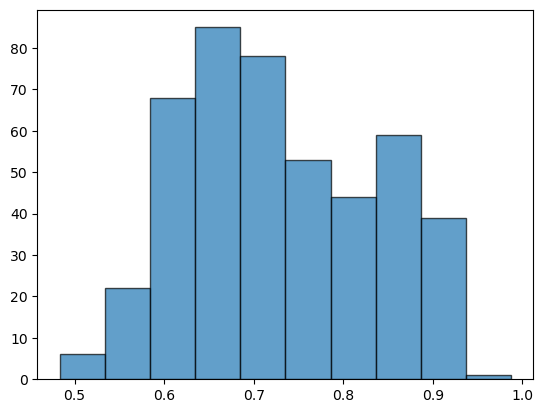

In [325]:
plt.hist(df_similarity['mean'], bins=10, alpha=0.7, edgecolor='black')

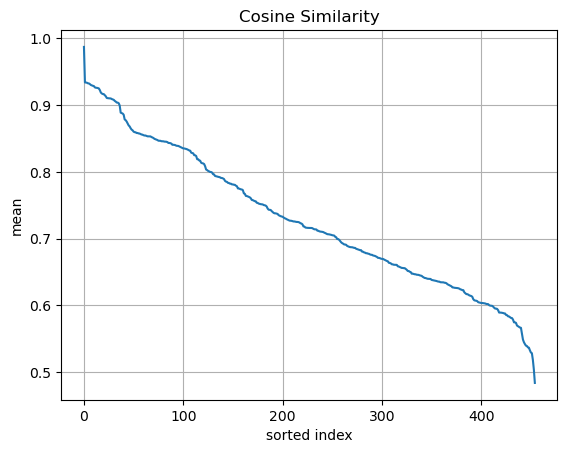

In [326]:
plt.plot(np.arange(df_similarity.shape[0]), df_similarity['mean'].sort_values(ascending=False))
plt.xlabel('sorted index')
plt.ylabel('mean')
plt.title('Cosine Similarity')
plt.grid()
plt.show()

In [327]:
threshold_dict = {
    'step_v1_mod': 0.95,
    'lasso_v1_mod': 0.88,
    'ridge_v1_mod': 0.80,
    'step_v2_mod': 0.85,
    'lasso_v2_mod': 0.80,
    'ridge_v2_mod': 0.70,
    
}
threshold = threshold_dict[f'{mod}_{version}']
threshold

0.7

In [328]:
df_similarity.sort_values('mean',ascending=False).iloc[350:390, :]

count      mean       std       min  \
group                                                                    
ridge_l2_05__2025032205480040       10.0  0.638114  0.069612  0.509291   
ridge_do_05__2025032205594910        6.0  0.637784  0.131645  0.421063   
ridge_small_mse__2025032211475710   10.0  0.637534  0.113488  0.533600   
ridge_l2_05__2025032205273850       10.0  0.637172  0.091614  0.465507   
ridge_do_05__2025032205303770       10.0  0.636741  0.071033  0.517661   
ridge_weight__2025032204182580      10.0  0.636448  0.068650  0.501131   
ridge_weight__2025032204194740      10.0  0.635898  0.090717  0.493743   
ridge_weight__2025032204040260      10.0  0.635539  0.095273  0.476242   
ridge_do_05__2025032205530390       10.0  0.635440  0.103175  0.521996   
ridge_weight__2025032204094850      10.0  0.634589  0.101147  0.425121   
ridge_small_mse__2025032211461020    3.0  0.634476  0.123203  0.493631   
ridge_do_03__2025032212065910       10.0  0.634471  0.085772  0.474551   
ridge_small_mse__2025032212473310   10.0  0.634429  0.094399  0.509505   
ridge_l2_06__2025032210493510       10.0  0.633862  0.083801  0.524543   
ridge_l2_04__2025032212382880        6.0  0.633716  0.060586  0.572529   
ridge_l2_06__2025032210435360       10.0  0.633076  0.083782  0.511462   
ridge_weight__2025032204164400      10.0  0.631629  0.064904  0.540166   
ridge_do_01__2025032212472510       10.0  0.630873  0.072858  0.520437   
ridge_l2_06__2025032210232560       10.0  0.630048  0.103445  0.492736   
ridge_do_05__2025032205310930       10.0  0.629440  0.094293  0.454685   
ridge_l2_06__2025032210101830       10.0  0.628550  0.071505  0.535780   
ridge_weight__2025032204172150      10.0  0.626880  0.094374  0.511762   
ridge_do_05__2025032207262850       10.0  0.626787  0.081016  0.483130   
ridge_do_03__2025032212035920       10.0  0.626330  0.070513  0.473857   
ridge_small_mse__2025032212202730   10.0  0.626189  0.091455  0.513823   
ridge_weight__2025032204200090      10.0  0.626002  0.075951  0.498053   
ridge_weight__2025032204261430      10.0  0.625869  0.059748  0.567107   
ridge_l2_06__2025032210492180       10.0  0.625566  0.086359  0.472620   
ridge_do_01__2025032211524720       10.0  0.624986  0.092340  0.500087   
ridge_do_03__2025032212141630        3.0  0.623946  0.099061  0.540142   
ridge_l2_06__2025032210164660       10.0  0.623571  0.086198  0.485917   
ridge_small_mse__2025032211462610   10.0  0.622765  0.091938  0.432873   
ridge_small_mse__2025032212481840   10.0  0.622713  0.089086  0.423445   
ridge_small_mse__2025032212210880   10.0  0.619507  0.114590  0.463999   
ridge_weight__2025032204251960      10.0  0.618137  0.084672  0.483109   
ridge_l2_05__2025032205290010       10.0  0.616844  0.090647  0.450342   
ridge_l2_05__2025032205280930       10.0  0.616734  0.057325  0.531848   
ridge_do_01__2025032212405350       10.0  0.616025  0.104497  0.438207   
ridge__2025032213482130             10.0  0.614933  0.112631  0.393023   
ridge_l2_05__2025032206050810       10.0  0.614353  0.093488  0.505602   

                                        25%       50%       75%       max  \
group                                                                       
ridge_l2_05__2025032205480040      0.604681  0.618209  0.690165  0.734926   
ridge_do_05__2025032205594910      0.588808  0.648992  0.722787  0.791529   
ridge_small_mse__2025032211475710  0.541910  0.603161  0.713934  0.851435   
ridge_l2_05__2025032205273850      0.582073  0.624829  0.704159  0.772409   
ridge_do_05__2025032205303770      0.606645  0.627679  0.675571  0.754387   
ridge_weight__2025032204182580     0.594726  0.653086  0.687969  0.724161   
ridge_weight__2025032204194740     0.580328  0.633035  0.682489  0.777670   
ridge_weight__2025032204040260     0.585459  0.645784  0.692630  0.801312   
ridge_do_05__2025032205530390      0.550469  0.606128  0.727093  0.801399   
ridge_weight__2025032204094850     0.629518  0.648319  0.703924  0.741518   
ri

In [329]:
df_cluster = df_similarity[df_similarity['mean']>threshold]
print(df_cluster.shape)
df_cluster.head()

(255, 9)


count      mean       std       min       25%  \
group                                                                    
ridge__2025032211345020   10.0  0.832876  0.022260  0.809151  0.816548   
ridge__2025032211531580   10.0  0.705982  0.058842  0.587650  0.682311   
ridge__2025032211545040   10.0  0.862182  0.023461  0.832334  0.850271   
ridge__2025032212074920   10.0  0.854423  0.041342  0.774658  0.830676   
ridge__2025032212193730   10.0  0.718239  0.050178  0.605351  0.696503   

                              50%       75%       max  max_diff  
group                                                            
ridge__2025032211345020  0.829600  0.841090  0.879257  0.070106  
ridge__2025032211531580  0.694431  0.740203  0.803197  0.215547  
ridge__2025032211545040  0.863798  0.869855  0.913382  0.081048  
ridge__2025032212074920  0.854492  0.879324  0.917280  0.142622  
ridge__2025032212193730  0.727131  0.739238  0.791840  0.186489

### clustering try (testing functionality)

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows wi

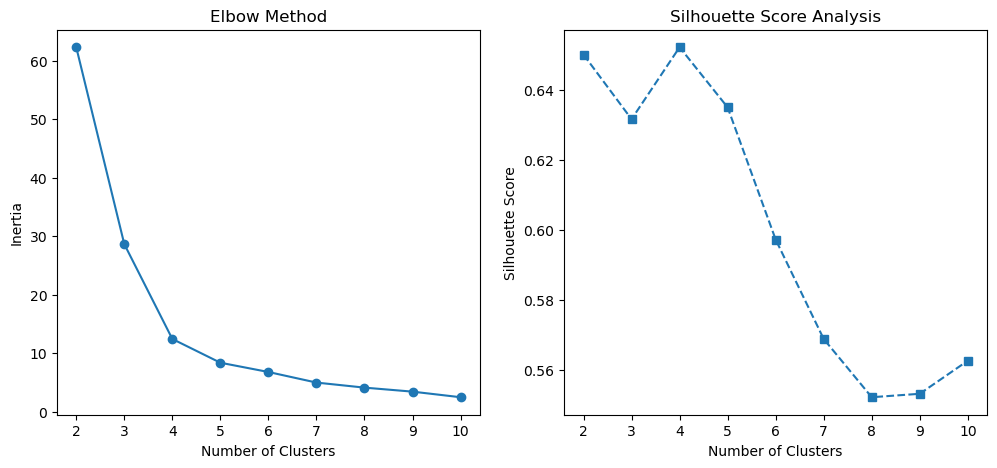

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



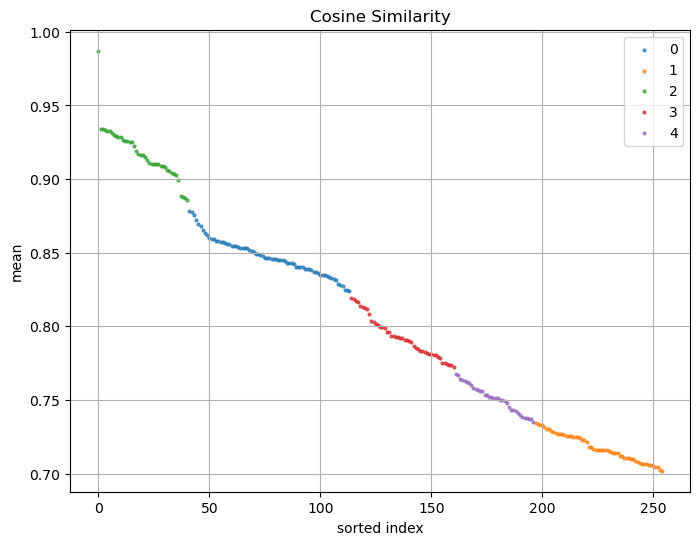

In [330]:
df1 = df_cluster.copy()
df1 = df1.sort_values('mean', ascending=False).reset_index()
df1 =df1[['mean']]

# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df1)

# Step 2: Finding the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # Trying different k values

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='s', linestyle='dashed')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")

plt.show()

# Step 3: Applying the chosen clustering method
optimal_k = 5 #np.argmax(silhouette_scores) + 2  # Selecting best k from silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df1['Cluster'] = kmeans.fit_predict(scaled_data)


plt.figure(figsize=(8, 6))
for cluster_id in range(optimal_k):
    df_help = df1[df1['Cluster'] == cluster_id]
    plt.scatter(df_help.index, 
                df_help['mean'], 
                label=cluster_id, alpha=0.7, s=4)
plt.xlabel('sorted index')
plt.ylabel('mean')
plt.title('Cosine Similarity')
plt.grid()
plt.legend()
plt.show()

### analyze histograms

In [331]:
# prepare df
df_cutoff = df[df['group'].isin(df_cluster.index)]
# Create aggregation dictionary
agg_dict = {col: 'max' for col in df_cutoff.columns}
agg_dict.update({col: 'mean' for col in features})
# calculate mean shap value in given time_id
df_cutoff = df_cutoff.groupby('group').agg(agg_dict)
df1 = df_cutoff[features]
print(df1.shape)
df1.head()

(255, 60)


cmr waty n it.f  imy-rA zS(w) a(w) (nw) ncwt  \
group                                                                   
ridge__2025032211345020         0.010402                     0.078257   
ridge__2025032211531580         0.030230                     0.047043   
ridge__2025032211545040         0.019447                     0.066024   
ridge__2025032212074920         0.013531                     0.069854   
ridge__2025032212193730         0.019006                     0.059955   

                           HAty-a  wr 5 (m) pr 9Hwty   iry-pat  imy-rA Snwty  \
group                                                                          
ridge__2025032211345020  0.094470           0.026723  0.091570      0.038998   
ridge__2025032211531580  0.050050           0.043585  0.052474      0.040328   
ridge__2025032211545040  0.090334           0.022836  0.094915      0.032827   
ridge__2025032212074920  0.106988           0.017068  0.101927      0.039851   
ridge__2025032212193730  0.062269           0.024375  0.062891      0.029162   

                         father_was_vizier       PC1       PC3       PC2  ...  \
group                                                                     ...   
ridge__2025032211345020           0.002307  0.007841  0.002569  0.000858  ...   
ridge__2025032211531580           0.001394  0.001561  0.000600  0.000326  ...   
ridge__2025032211545040           0.002381  0.006961  0.002204  0.000569  ...   
ridge__2025032212074920           0.000957  0.005759  0.002253  0.000591  ...   
ridge__2025032212193730           0.001268  0.001819  0.000788  0.000375  ...   

                          Xry-Hbt  cHD Hm(w)-nTr 9d-cwt-6ti     imA-a  \
group                                                                   
ridge__2025032211345020  0.004377                  0.012552  0.009428   
ridge__2025032211531580  0.003162                  0.015199  0.006943   
ridge__2025032211545040  0.003617                  0.007450  0.006492   
ridge__2025032212074920  0.006030                  0.014727  0.006002   
ridge__2025032212193730  0.001375                  0.019991  0.011327   

                         imy-ib n ncwt m ct.f nbt    imy iz    r P nb  \
group                                                                   
ridge__2025032211345020                  0.015960  0.007891  0.012147   
ridge__2025032211531580                  0.016097  0.014967  0.009069   
ridge__2025032211545040                  0.008362  0.013777  0.012242   
ridge__2025032212074920                  0.016712  0.018438  0.010341   
ridge__2025032212193730                  0.012917  0.025970  0.012463   

                         xrp Hwwt Nt  Hry-tp Nxb  cmcw cnwt  HAty-a mAa  
group                                                                    
ridge__2025032211345020     0.012397    0.007950   0.006275    0.004278  
ridge__2025032211531580     0.013658    0.008747   0.007708    0.014493  
ridge__2025032211545040     0.006341    0.009757   0.019708    0.005165  
ridge__2025032212074920     0.010541    0.002628   0.011624    0.005558  
ridge__2025032212193730     0.015339    0.022959   0.029266    0.000505  

[5 rows x 60 columns]

In [332]:
def plot_histogram(df, column):
    # Check if the column exists in the DataFrame
    if column not in df.columns:
        print(f"The column '{column}' does not exist in the DataFrame.")
        return

    # Plotting the histogram with a density curve
    sns.set(style='whitegrid')  # Setting the style to 'whitegrid' for better visibility
    plt.figure(figsize=(5, 4))  # Setting the size of the figure
    sns.histplot(df[column], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram and Density Plot of {column}')  # Title of the plot
    plt.xlabel(column)  # Label on X-axis
    plt.ylabel('Frequency')  # Label on Y-axis
    plt.show()

In [333]:
def plot_histograms_df(df):
    num_columns = len(df.columns)  # Get the number of columns in the DataFrame
    num_rows = (num_columns + 1) // 2  # Calculate the number of rows needed for two columns
    plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure size dynamically based on number of rows
    plt.suptitle(f'{file_name}', y=0.999, fontsize=18)

    min_val = np.floor(df.min().min()*100 - 1)/100
    max_val = np.ceil(df.max().max()*100 + 1)/100
    
    for i, column in enumerate(df.columns):
        plt.subplot(num_rows, 2, i + 1)  # Create subplot for each column
        sns.histplot(df[column], kde=True, bins=30, color='skyblue', edgecolor='black')
        plt.title(f'SHAP values for "{column}"')  # Title of the plot
        plt.xlabel(column)  # Label on X-axis
        plt.ylabel('Frequency')  # Label on Y-axis
        plt.xlim([max(min_val, 0), max_val])
    
    plt.tight_layout()
    
    # Save as PNG and PDF
    plt.savefig(f'img/{file_name}.png', format='png')
    plt.savefig(f'img/{file_name}.pdf', format='pdf')
    
    plt.show()

In [334]:
def plot_histograms_df_cluster(df, cluster_col='Cluster'):
    """
    Plots histograms for all numerical columns in the dataframe,
    with histograms split by unique levels of the categorical column `cluster_col`.

    Parameters:
    df : pandas DataFrame
        Input dataframe containing numerical columns and a categorical column to split by.
    cluster_col : str, optional
        The column to use for splitting the data into different histograms (default is 'Cluster').
    """
    if cluster_col not in df.columns:
        raise ValueError(f"Column '{cluster_col}' not found in DataFrame")

    unique_clusters = sorted(df[cluster_col].dropna().unique())  # Get sorted unique cluster values
    num_columns = len(df.columns) - 1  # Exclude the 'Cluster' column from numeric columns
    num_rows = (num_columns + 1) // 2  # Calculate number of rows needed for two columns

    plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure size dynamically based on number of rows
    plt.suptitle(f'{file_name}', y=0.999, fontsize=18)
    df_drop = df.drop(columns=[cluster_col])
    min_val = np.floor(df_drop.min().min()*100 - 1)/100
    max_val = np.ceil(df_drop.max().max()*100 + 1)/100

    for i, column in enumerate(df_drop.columns):
        plt.subplot(num_rows, 2, i + 1)  # Create subplot for each column

        for cluster in unique_clusters:
            subset = df[df[cluster_col] == cluster]
            sns.histplot(subset[column], kde=True, bins=30, label=f'Cluster {cluster}', alpha=0.5, edgecolor='black')

        plt.title(f'{column}')  # Title of the plot
        plt.xlabel(f'SHAP value')  # Label on X-axis
        plt.ylabel('Frequency')  # Label on Y-axis

        # Set consistent x-axis limits based on global min/max values across all clusters
        plt.xlim([max(min_val, 0), max_val])

        plt.legend()  # Show legend to differentiate clusters

    plt.tight_layout()

    # Ensure the 'img' directory exists before saving files
    os.makedirs("img", exist_ok=True)
    
    # Save as PNG and PDF
    plt.savefig(f'img/{file_name}_cluster_{len(unique_clusters)}.png', format='png')
    plt.savefig(f'img/{file_name}_cluster_{len(unique_clusters)}.pdf', format='pdf')

    plt.show()

In [335]:
def plot_histograms_df_cluster_v2(df, cluster_col='Cluster'):
    """
    Plots histograms for all numerical columns in the dataframe,
    with histograms split by unique levels of the categorical column `cluster_col`.

    Parameters:
    df : pandas DataFrame
        Input dataframe containing numerical columns and a categorical column to split by.
    cluster_col : str, optional
        The column to use for splitting the data into different histograms (default is 'Cluster').
    """
    if cluster_col not in df.columns:
        raise ValueError(f"Column '{cluster_col}' not found in DataFrame")

    unique_clusters = sorted(df[cluster_col].dropna().unique())  # Get sorted unique cluster values
    num_columns = len(df.columns) - 1  # Exclude the 'Cluster' column from numeric columns
    num_rows = (num_columns + 1) // 2  # Calculate number of rows needed for two columns

    plt.figure(figsize=(24, 4 * num_rows))  # Adjust figure size dynamically based on number of rows
    plt.suptitle(f'{file_name}', y=0.999, fontsize=18)
    df_drop = df.drop(columns=[cluster_col])
    min_val = np.floor(df_drop.min().min()*100 - 1)/100
    max_val = np.ceil(df_drop.max().max()*100 + 1)/100

    for i, column in enumerate(df_drop.columns):

        # plot normal histogram
        plt.subplot(num_rows, 4, 2*i + 1)  # Create subplot for each column
        sns.histplot(df[column], kde=True, bins=30, color='skyblue', edgecolor='black')
        plt.title(f'{column}')  # Title of the plot
        plt.xlabel(f'SHAP value')  # Label on X-axis
        plt.ylabel('Frequency')  # Label on Y-axis
        plt.xlim([max(min_val, 0), max_val])

        # plot histogram with clusters
        plt.subplot(num_rows, 4, 2*i + 2)  # Create subplot for each column
        for cluster in unique_clusters:
            subset = df[df[cluster_col] == cluster]
            sns.histplot(subset[column], kde=True, bins=30, label=f'Cluster {cluster}', alpha=0.5, edgecolor='black')

        plt.title(f'{column}')  # Title of the plot
        plt.xlabel(f'SHAP value')  # Label on X-axis
        plt.ylabel('Frequency')  # Label on Y-axis

        # Set consistent x-axis limits based on global min/max values across all clusters
        plt.xlim([max(min_val, 0), max_val])

        plt.legend()  # Show legend to differentiate clusters

    plt.tight_layout()

    # Ensure the 'img' directory exists before saving files
    os.makedirs("img", exist_ok=True)
    
    # Save as PNG and PDF
    plt.savefig(f'img/{file_name}_cluster_{len(unique_clusters)}_big.png', format='png')
    plt.savefig(f'img/{file_name}_cluster_{len(unique_clusters)}_big.pdf', format='pdf')

    plt.show()

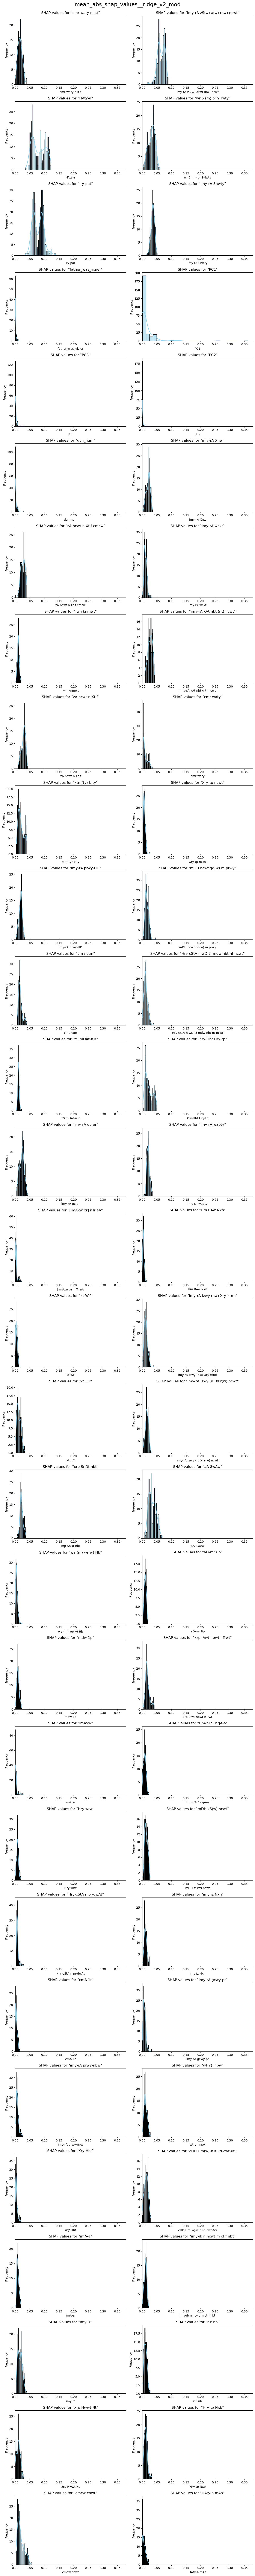

In [336]:
plot_histograms_df(df1)

### clustering

In [337]:
df_cluster.head(2)

count      mean       std       min       25%  \
group                                                                    
ridge__2025032211345020   10.0  0.832876  0.022260  0.809151  0.816548   
ridge__2025032211531580   10.0  0.705982  0.058842  0.587650  0.682311   

                              50%       75%       max  max_diff  
group                                                            
ridge__2025032211345020  0.829600  0.841090  0.879257  0.070106  
ridge__2025032211531580  0.694431  0.740203  0.803197  0.215547

In [338]:
# prepare df
df_cutoff = df[df['group'].isin(df_cluster.index)]
# Create aggregation dictionary
agg_dict = {col: 'max' for col in df_cutoff.columns}
agg_dict.update({col: 'mean' for col in features})
# calculate mean shap value in given time_id
df_cutoff = df_cutoff.groupby('group').agg(agg_dict)
df1 = df_cutoff[features]
print(df1.shape)
df1.head()

(255, 60)


cmr waty n it.f  imy-rA zS(w) a(w) (nw) ncwt  \
group                                                                   
ridge__2025032211345020         0.010402                     0.078257   
ridge__2025032211531580         0.030230                     0.047043   
ridge__2025032211545040         0.019447                     0.066024   
ridge__2025032212074920         0.013531                     0.069854   
ridge__2025032212193730         0.019006                     0.059955   

                           HAty-a  wr 5 (m) pr 9Hwty   iry-pat  imy-rA Snwty  \
group                                                                          
ridge__2025032211345020  0.094470           0.026723  0.091570      0.038998   
ridge__2025032211531580  0.050050           0.043585  0.052474      0.040328   
ridge__2025032211545040  0.090334           0.022836  0.094915      0.032827   
ridge__2025032212074920  0.106988           0.017068  0.101927      0.039851   
ridge__2025032212193730  0.062269           0.024375  0.062891      0.029162   

                         father_was_vizier       PC1       PC3       PC2  ...  \
group                                                                     ...   
ridge__2025032211345020           0.002307  0.007841  0.002569  0.000858  ...   
ridge__2025032211531580           0.001394  0.001561  0.000600  0.000326  ...   
ridge__2025032211545040           0.002381  0.006961  0.002204  0.000569  ...   
ridge__2025032212074920           0.000957  0.005759  0.002253  0.000591  ...   
ridge__2025032212193730           0.001268  0.001819  0.000788  0.000375  ...   

                          Xry-Hbt  cHD Hm(w)-nTr 9d-cwt-6ti     imA-a  \
group                                                                   
ridge__2025032211345020  0.004377                  0.012552  0.009428   
ridge__2025032211531580  0.003162                  0.015199  0.006943   
ridge__2025032211545040  0.003617                  0.007450  0.006492   
ridge__2025032212074920  0.006030                  0.014727  0.006002   
ridge__2025032212193730  0.001375                  0.019991  0.011327   

                         imy-ib n ncwt m ct.f nbt    imy iz    r P nb  \
group                                                                   
ridge__2025032211345020                  0.015960  0.007891  0.012147   
ridge__2025032211531580                  0.016097  0.014967  0.009069   
ridge__2025032211545040                  0.008362  0.013777  0.012242   
ridge__2025032212074920                  0.016712  0.018438  0.010341   
ridge__2025032212193730                  0.012917  0.025970  0.012463   

                         xrp Hwwt Nt  Hry-tp Nxb  cmcw cnwt  HAty-a mAa  
group                                                                    
ridge__2025032211345020     0.012397    0.007950   0.006275    0.004278  
ridge__2025032211531580     0.013658    0.008747   0.007708    0.014493  
ridge__2025032211545040     0.006341    0.009757   0.019708    0.005165  
ridge__2025032212074920     0.010541    0.002628   0.011624    0.005558  
ridge__2025032212193730     0.015339    0.022959   0.029266    0.000505  

[5 rows x 60 columns]

(255, 60)


C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows wi

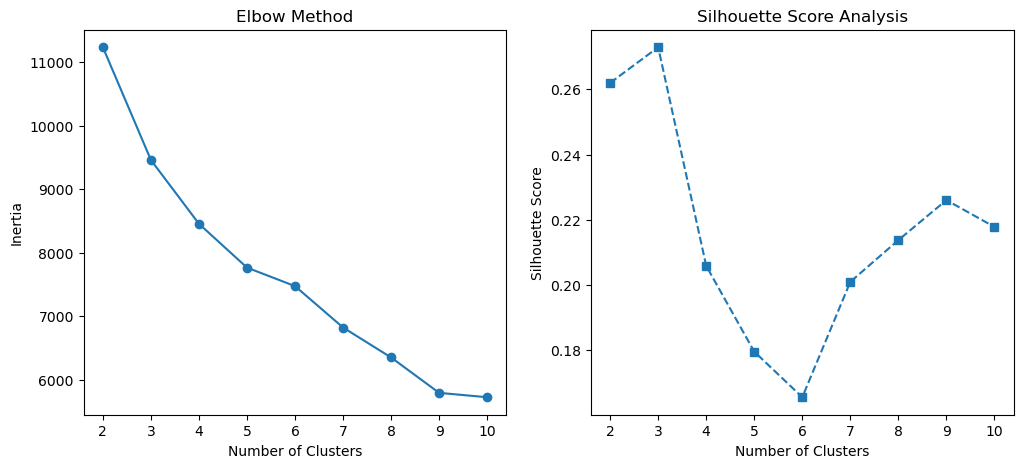

3


C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\anaconda3\envs\dip2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Stoja\AppData\Local\Temp\ipykernel_25704\3311844800.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cmr waty n it.f  imy-rA zS(w) a(w) (nw) ncwt  \
group                                                                   
ridge__2025032211345020         0.010402                     0.078257   
ridge__2025032211531580         0.030230                     0.047043   
ridge__2025032211545040         0.019447                     0.066024   
ridge__2025032212074920         0.013531                     0.069854   
ridge__2025032212193730         0.019006                     0.059955   

                           HAty-a  wr 5 (m) pr 9Hwty   iry-pat  imy-rA Snwty  \
group                                                                          
ridge__2025032211345020  0.094470           0.026723  0.091570      0.038998   
ridge__2025032211531580  0.050050           0.043585  0.052474      0.040328   
ridge__2025032211545040  0.090334           0.022836  0.094915      0.032827   
ridge__2025032212074920  0.106988           0.017068  0.101927      0.039851   
ridge__2025032212193730  0.062269           0.024375  0.062891      0.029162   

                         father_was_vizier       PC1       PC3       PC2  ...  \
group                                                                     ...   
ridge__2025032211345020           0.002307  0.007841  0.002569  0.000858  ...   
ridge__2025032211531580           0.001394  0.001561  0.000600  0.000326  ...   
ridge__2025032211545040           0.002381  0.006961  0.002204  0.000569  ...   
ridge__2025032212074920           0.000957  0.005759  0.002253  0.000591  ...   
ridge__2025032212193730           0.001268  0.001819  0.000788  0.000375  ...   

                         cHD Hm(w)-nTr 9d-cwt-6ti     imA-a  \
group                                                         
ridge__2025032211345020                  0.012552  0.009428   
ridge__2025032211531580                  0.015199  0.006943   
ridge__2025032211545040                  0.007450  0.006492   
ridge__2025032212074920                  0.014727  0.006002   
ridge__2025032212193730                  0.019991  0.011327   

                         imy-ib n ncwt m ct.f nbt    imy iz    r P nb  \
group                                                                   
ridge__2025032211345020                  0.015960  0.007891  0.012147   
ridge__2025032211531580                  0.016097  0.014967  0.009069   
ridge__2025032211545040                  0.008362  0.013777  0.012242   
ridge__2025032212074920                  0.016712  0.018438  0.010341   
ridge__2025032212193730                  0.012917  0.025970  0.012463   

                         xrp Hwwt Nt  Hry-tp Nxb  cmcw cnwt  HAty-a mAa  \
group                                                                     
ridge__2025032211345020     0.012397    0.007950   0.006275    0.004278   
ridge__2025032211531580     0.013658    0.008747   0.007708    0.014493   
ridge__2025032211545040     0.006341    0.009757   0.019708    0.005165   
ridge__2025032212074920     0.010541    0.002628   0.011624    0.005558   
ridge__2025032212193730     0.015339    0.022959   0.029266    0.000505   

                         Cluster  
group                             
ridge__2025032211345020        0  
ridge__2025032211531580        1  
ridge__2025032211545040        0  
ridge__2025032212074920        0  
ridge__2025032212193730        1  

[5 rows x 61 columns]

In [339]:
print(df1.shape)

# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df1)

# Step 2: Finding the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # Trying different k values

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='s', linestyle='dashed')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Analysis")

plt.show()

# Step 3: Applying the chosen clustering method
optimal_k = k_clusters #np.argmax(silhouette_scores) + 2  # Selecting best k from silhouette score
print(optimal_k)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_cutoff['Cluster'] = kmeans.fit_predict(scaled_data)
df1['Cluster'] = kmeans.fit_predict(scaled_data)
df_cutoff['Cluster'] = df_cutoff['Cluster'].astype(str)
df1.head()

In [340]:
df1[df1['Cluster']==0].describe()

cmr waty n it.f  imy-rA zS(w) a(w) (nw) ncwt     HAty-a  \
count        82.000000                    82.000000  82.000000   
mean          0.011702                     0.074602   0.106321   
std           0.004523                     0.006630   0.008908   
min           0.004283                     0.043772   0.071278   
25%           0.008481                     0.071789   0.101981   
50%           0.010961                     0.074723   0.105917   
75%           0.013972                     0.078201   0.113260   
max           0.026946                     0.088759   0.123503   

       wr 5 (m) pr 9Hwty    iry-pat  imy-rA Snwty  father_was_vizier  \
count          82.000000  82.000000     82.000000          82.000000   
mean            0.023965   0.093937      0.038054           0.001649   
std             0.007420   0.007597      0.005320           0.000491   
min             0.011059   0.058860      0.027012           0.000595   
25%             0.017606   0.090343      0.034193           0.001307   
50%             0.022688   0.093923      0.037837           0.001635   
75%             0.029804   0.097537      0.041937           0.001971   
max             0.040823   0.119640      0.049312           0.002583   

             PC1        PC3        PC2  ...  cHD Hm(w)-nTr 9d-cwt-6ti  \
count  82.000000  82.000000  82.000000  ...                 82.000000   
mean    0.021874   0.003733   0.001383  ...                  0.007721   
std     0.030058   0.002403   0.001099  ...                  0.004402   
min     0.003035   0.000720   0.000233  ...                  0.000736   
25%     0.006615   0.002285   0.000666  ...                  0.003873   
50%     0.011251   0.002627   0.000928  ...                  0.007299   
75%     0.034716   0.005526   0.001963  ...                  0.010971   
max     0.257996   0.017753   0.008834  ...                  0.020217   

           imA-a  imy-ib n ncwt m ct.f nbt     imy iz     r P nb  xrp Hwwt Nt  \
count  82.000000                 82.000000  82.000000  82.000000    82.000000   
mean    0.009560                  0.008171   0.010425   0.008385     0.006178   
std     0.003234                  0.004522   0.004558   0.003102     0.004331   
min     0.003528                  0.000685   0.002916   0.002089     0.000125   
25%     0.007108                  0.004624   0.007188   0.005913     0.002420   
50%     0.009392                  0.007679   0.009354   0.008273     0.005425   
75%     0.011831                  0.010445   0.012511   0.010610     0.009007   
max     0.018318                  0.021737   0.022699   0.016142     0.019609   

       Hry-tp Nxb  cmcw cnwt    HAty-a mAa  Cluster  
count   82.000000  82.000000  8.200000e+01     82.0  
mean     0.007322   0.011484  2.800774e-03      0.0  
std      0.002842   0.004616  2.855581e-03      0.0  
min      0.002345   0.002899  1.575795e-07      0.0  
25%      0.005380   0.008638  1.793744e-04      0.0  
50%      0.006917   0.010925  2.075017e-03      0.0  
75%      0.008898   0.013691  4.313807e-03      0.0  
max      0.014908   0.022770  1.244068e-02      0.0  

[8 rows x 61 columns]

In [341]:
df1[df1['Cluster']==1].describe()

cmr waty n it.f  imy-rA zS(w) a(w) (nw) ncwt      HAty-a  \
count       141.000000                   141.000000  141.000000   
mean          0.022032                     0.062925    0.066438   
std           0.005933                     0.010053    0.012991   
min           0.010706                     0.039166    0.045213   
25%           0.017553                     0.056111    0.056826   
50%           0.021103                     0.059675    0.061761   
75%           0.026045                     0.069501    0.077535   
max           0.040452                     0.083328    0.093719   

       wr 5 (m) pr 9Hwty     iry-pat  imy-rA Snwty  father_was_vizier  \
count         141.000000  141.000000    141.000000         141.000000   
mean            0.040436    0.069276      0.037278           0.001808   
std             0.006925    0.012522      0.005121           0.000627   
min             0.017800    0.042411      0.023665           0.000752   
25%             0.036332    0.060133      0.034423           0.001393   
50%             0.039920    0.065443      0.037514           0.001700   
75%             0.044883    0.080801      0.040720           0.002127   
max             0.061308    0.094948      0.051499           0.005023   

              PC1         PC3         PC2  ...  cHD Hm(w)-nTr 9d-cwt-6ti  \
count  141.000000  141.000000  141.000000  ...                141.000000   
mean     0.002557    0.001000    0.000507  ...                  0.017174   
std      0.001273    0.000351    0.000385  ...                  0.004488   
min      0.001081    0.000333    0.000225  ...                  0.007410   
25%      0.001582    0.000747    0.000339  ...                  0.014022   
50%      0.002379    0.000974    0.000419  ...                  0.017102   
75%      0.003148    0.001181    0.000535  ...                  0.019743   
max      0.010220    0.002368    0.003474  ...                  0.028143   

            imA-a  imy-ib n ncwt m ct.f nbt      imy iz      r P nb  \
count  141.000000                141.000000  141.000000  141.000000   
mean     0.009748                  0.013079    0.021334    0.013152   
std      0.003596                  0.002804    0.006127    0.004813   
min      0.004688                  0.004757    0.005797    0.002365   
25%      0.006727                  0.011348    0.017516    0.009807   
50%      0.008858                  0.012917    0.021011    0.013790   
75%      0.011928                  0.015139    0.024581    0.016824   
max      0.018715                  0.021120    0.039766    0.025983   

       xrp Hwwt Nt  Hry-tp Nxb   cmcw cnwt  HAty-a mAa  Cluster  
count   141.000000  141.000000  141.000000  141.000000    141.0  
mean      0.015631    0.013986    0.025448    0.009362      1.0  
std       0.004420    0.003774    0.011268    0.005224      0.0  
min       0.007865    0.006690    0.005504    0.000229      1.0  
25%       0.012009    0.011432    0.016605    0.005306      1.0  
50%       0.015057    0.013562    0.024665    0.009192      1.0  
75%       0.018686    0.016093    0.033141    0.012929      1.0  
max       0.030469    0.032935    0.056840    0.023200      1.0  

[8 rows x 61 columns]

In [342]:
mean_0 = df1[df1['Cluster']==0].describe().loc['mean']
mean_1 = df1[df1['Cluster']==1].describe().loc['mean']
pd.concat([mean_0, mean_1], axis=1).transpose()

cmr waty n it.f  imy-rA zS(w) a(w) (nw) ncwt    HAty-a  \
mean         0.011702                     0.074602  0.106321   
mean         0.022032                     0.062925  0.066438   

      wr 5 (m) pr 9Hwty   iry-pat  imy-rA Snwty  father_was_vizier       PC1  \
mean           0.023965  0.093937      0.038054           0.001649  0.021874   
mean           0.040436  0.069276      0.037278           0.001808  0.002557   

           PC3       PC2  ...  cHD Hm(w)-nTr 9d-cwt-6ti     imA-a  \
mean  0.003733  0.001383  ...                  0.007721  0.009560   
mean  0.001000  0.000507  ...                  0.017174  0.009748   

      imy-ib n ncwt m ct.f nbt    imy iz    r P nb  xrp Hwwt Nt  Hry-tp Nxb  \
mean                  0.008171  0.010425  0.008385     0.006178    0.007322   
mean                  0.013079  0.021334  0.013152     0.015631    0.013986   

      cmcw cnwt  HAty-a mAa  Cluster  
mean   0.011484    0.002801      0.0  
mean   0.025448    0.009362      1.0  

[2 rows x 61 columns]

In [343]:
# Create an interactive scatter plot
df_c = df_cutoff  # Renaming df to df_c
mask1 = df_c['model param'] != ''
df_c = df_c[mask1]  # Applying filters

# Define axis columns
column_x = 'loss'
column_y = 'persons_in_overlap'

# Create interactive scatter plot
fig = px.scatter(df_c,
                 x=column_x, 
                 y=column_y,
                 color='Cluster',
                 title=f'Interactive Scatter Plot: {column_x} vs {column_y}',
                 hover_data=df_c.columns)

# Set custom size (adjust width and height as needed)
fig.update_layout(
    width=800,  # Adjust width (default is ~700)
    height=500   # Adjust height (default is ~450)
)

# Show the plot
fig.show()

In [344]:
df_cutoff['Cluster'].value_counts()

Cluster
1    141
0     82
2     32
Name: count, dtype: int64

In [345]:
# Create an interactive scatter plot
df_c = df_cutoff  # Renaming df to df_c
mask1 = df_c['model param'] != ''
cluster_id = 0
mask2 = df_c['Cluster'] == str(cluster_id)
df_c = df_c[mask1 & mask2]  # Applying filters

# Define axis columns
column_x = 'loss'
column_y = 'persons_in_overlap'

# Create interactive scatter plot
fig = px.scatter(df_c,
                 x=column_x, 
                 y=column_y,
                 color='type',
                 title=f'Cluster {cluster_id}: {column_x} vs {column_y}',
                 hover_data=df_c.columns)

# Set custom size (adjust width and height as needed)
fig.update_layout(
    width=800,  # Adjust width (default is ~700)
    height=500   # Adjust height (default is ~450)
)

# Show the plot
fig.show()

In [346]:
# Create an interactive scatter plot
df_c = df_cutoff  # Renaming df to df_c
mask1 = df_c['model param'] != ''
cluster_id = 1
mask2 = df_c['Cluster'] == str(cluster_id)
df_c = df_c[mask1 & mask2]  # Applying filters

# Define axis columns
column_x = 'loss'
column_y = 'persons_in_overlap'

# Create interactive scatter plot
fig = px.scatter(df_c,
                 x=column_x, 
                 y=column_y,
                 color='type',
                 title=f'Cluster {cluster_id}: {column_x} vs {column_y}',
                 hover_data=df_c.columns)

# Set custom size (adjust width and height as needed)
fig.update_layout(
    width=800,  # Adjust width (default is ~700)
    height=500   # Adjust height (default is ~450)
)

# Show the plot
fig.show()

In [347]:
# Create an interactive scatter plot
df_c = df_cutoff  # Renaming df to df_c
mask1 = df_c['model param'] != ''
cluster_id = 2
mask2 = df_c['Cluster'] == str(cluster_id)
df_c = df_c[mask1 & mask2]  # Applying filters

# Define axis columns
column_x = 'loss'
column_y = 'persons_in_overlap'

# Create interactive scatter plot
fig = px.scatter(df_c,
                 x=column_x, 
                 y=column_y,
                 color='type',
                 title=f'Cluster {cluster_id}: {column_x} vs {column_y}',
                 hover_data=df_c.columns)

# Set custom size (adjust width and height as needed)
fig.update_layout(
    width=800,  # Adjust width (default is ~700)
    height=500   # Adjust height (default is ~450)
)

# Show the plot
fig.show()

In [348]:
# Create an interactive scatter plot
df_c = df_cutoff  # Renaming df to df_c
mask1 = df_c['model param'] != ''
cluster_id = 3
mask2 = df_c['Cluster'] == str(cluster_id)
df_c = df_c[mask1 & mask2]  # Applying filters

# Define axis columns
column_x = 'loss'
column_y = 'persons_in_overlap'

# Create interactive scatter plot
fig = px.scatter(df_c,
                 x=column_x, 
                 y=column_y,
                 color='type',
                 title=f'Cluster {cluster_id}: {column_x} vs {column_y}',
                 hover_data=df_c.columns)

# Set custom size (adjust width and height as needed)
fig.update_layout(
    width=800,  # Adjust width (default is ~700)
    height=500   # Adjust height (default is ~450)
)

# Show the plot
fig.show()

In [349]:
# Create an interactive scatter plot
df_c = df_cutoff  # Renaming df to df_c
mask1 = df_c['model param'] != ''
cluster_id = 4
mask2 = df_c['Cluster'] == str(cluster_id)
df_c = df_c[mask1 & mask2]  # Applying filters

# Define axis columns
column_x = 'loss'
column_y = 'persons_in_overlap'

# Create interactive scatter plot
fig = px.scatter(df_c,
                 x=column_x, 
                 y=column_y,
                 color='type',
                 title=f'Cluster {cluster_id}: {column_x} vs {column_y}',
                 hover_data=df_c.columns)

# Set custom size (adjust width and height as needed)
fig.update_layout(
    width=800,  # Adjust width (default is ~700)
    height=500   # Adjust height (default is ~450)
)

# Show the plot
fig.show()

In [350]:
file_name

'mean_abs_shap_values__ridge_v2_mod'

### results

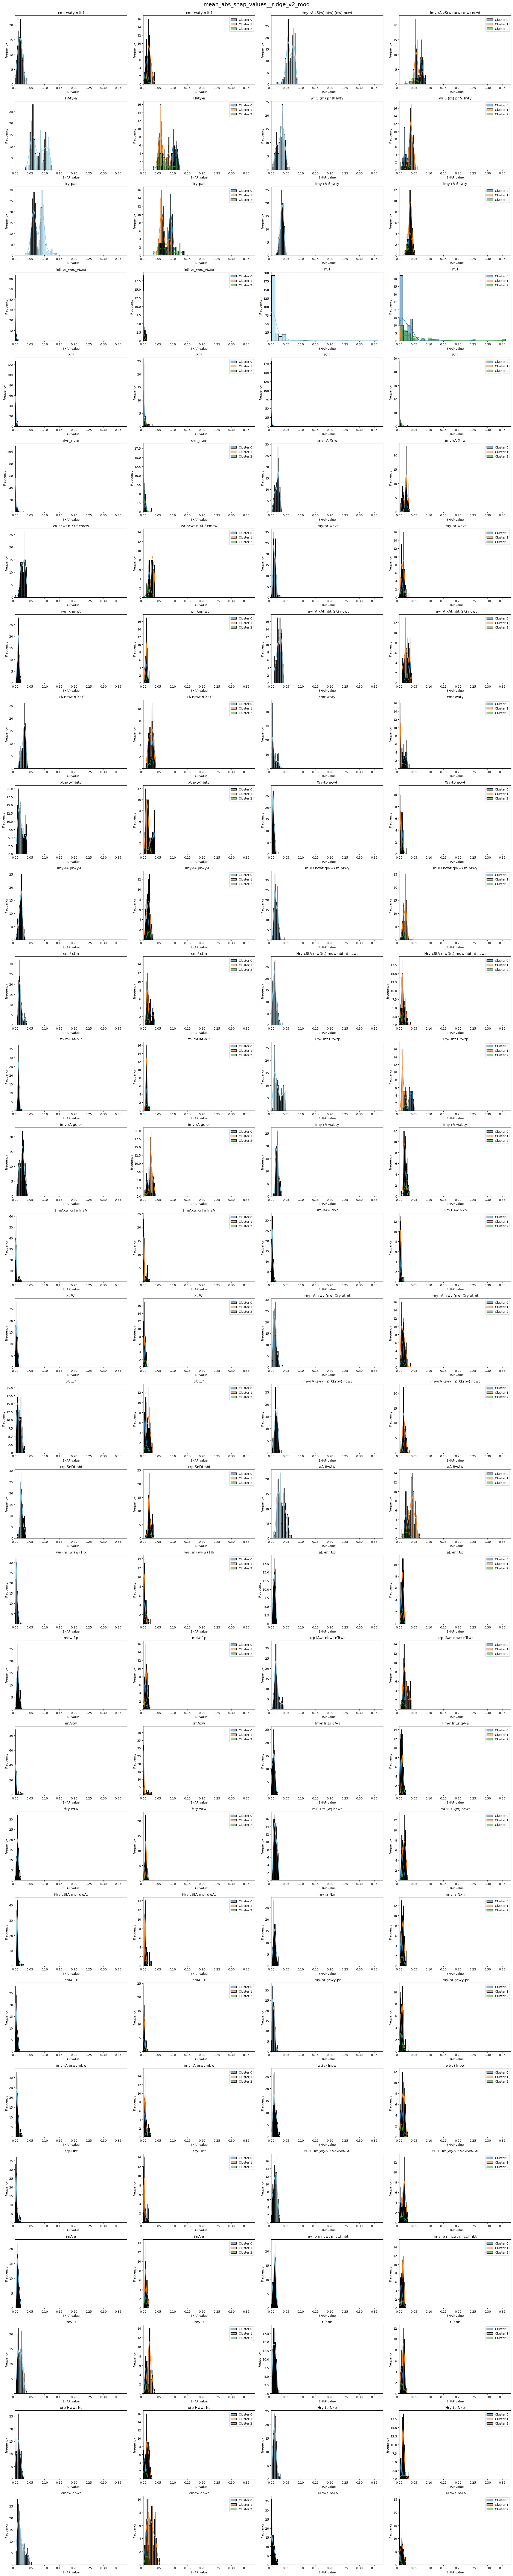

In [351]:
plot_histograms_df_cluster_v2(df1)

In [352]:
# Create an interactive scatter plot
df_c = df.copy()
df_c['group'] = df_c['file_name'].apply(lambda x: x[:-6])
df_c = df_c.groupby('group').max()
df_c.shape

df_c = pd.merge(df_c, df_cutoff[['Cluster']], left_index=True, right_index=True, how="left")
df_c['Cluster'] = df_c['Cluster'].fillna("nan")

# Define axis columns
column_x = 'loss'
column_y = 'persons_in_overlap'

# Create interactive scatter plot
fig = px.scatter(df_c,
                 x=column_x, 
                 y=column_y,
                 color='Cluster',
                 symbol='model modification',
                 title=f'Interactive Scatter Plot: {column_x} vs {column_y}',
                 hover_data=df_c.columns)

# Set custom size (adjust width and height as needed)
fig.update_layout(
    width=800,  # Adjust width (default is ~700)
    height=500   # Adjust height (default is ~450)
)

print(f'{df_c.shape}\t shape of df')
# Show the plot
fig.show()

(497, 87)	 shape of df
